In [1]:
# imports
import ROOT
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('/exp/icarus/app/users/lkashur/medulla/medulla/spineplot/styles/pi0ana.mplstyle')
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from scipy.special import erf
from scipy.optimize import curve_fit
from scipy.stats import norm
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
#from concurrent.futures import ThreadPoolExecutor
import gc

## Helper functions

In [2]:
def transform_as(cov, param):
    """
    Apply a scale correction to the covariance matrix. This is
    intended to be used when the covariance matrix is meant to be
    rescaled to a different exposure, or for the case where the
    spectrum is being area normalized. The former case is realized
    by a "simple" scale correction (i.e. the covariance matrix is
    multiplied by the square of the scale). The latter case is
    realized by a "normalized" scale correction (i.e. the
    covariance matrix is properly transformed to account for how
    the area normalization impacts the covariance matrix).

    Parameters
    ----------
    cov : numpy.ndarray
        The covariance matrix to transform.
    param : float or np.ndarray
        The parameter to use for the transformation. For a "simple"
        scale correction, this is a float. For a "normalized" scale
        correction, this is a numpy array with the same shape as
        `cov` and containing the bin contents of the histogram.
    
    Returns
    -------
    numpy.ndarray
        The transformed covariance matrix.
    """
    if np.isscalar(param):
        return cov * param**2

    else:
        A = np.sum(param)
        y = param.reshape(-1, 1)
        delta = np.eye(len(y))
        jacobian = (delta * A - y) / A**2
        return jacobian @ cov @ jacobian.T

def draw_error_boxes(ax, x, y, xerr, yerr, **kwargs):
    """
    Adds error boxes to the input axis.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis to which the error boxes are to be added.
    x : numpy.array
        The x-coordinates of the error boxes.
    y : numpy.array
        The y-coordinates of the error boxes.
    xerr : numpy.array
        The x-error values of the error boxes.
    yerr : numpy.array
        The y-error values of the error boxes.
    kwargs: dict
        Keyword arguments to be passed to the errorbar function.

    Returns
    -------
    None.
    """
    boxes = [Rectangle((x[i] - xerr[i], y[i] - yerr[i]), 2 * np.abs(xerr[i]), 2 * yerr[i]) for i in range(len(x)) if y[i] > 0]
    pc = PatchCollection(boxes, **kwargs)
    ax.add_collection(pc)

def add_plot_labels(ax, pot, vadj=0.025, ana_status=str(), title=str()):
    xrange = ax.get_xlim() 
    yrange = ax.get_ylim()                                                                                                                     

    usex = xrange[0]
    usey = yrange[1] + 0.01*(yrange[1] - yrange[0]) + vadj*(yrange[1] - yrange[0])
    #s = r'$\bf{ICARUS}$ Work-in-Progress'
    ax.text(x=usex, y=usey, s=ana_status, fontsize=13, color='#d67a11')   
    
    usex = xrange[1]
    usey = yrange[1] + 0.01*(yrange[1] - yrange[0]) + vadj*(yrange[1] - yrange[0])
    mag = int(np.floor(np.log10(pot)))
    usepot = pot/10**mag
    s = f'{usepot:.2f}'+f'$\\times 10^{{{mag}}}$ POT'
    ax.text(x=usex, y=usey, s=s, fontsize=13, color='black', horizontalalignment='right')

def ndarray_to_tmatrixtsym(np_array):
    size = np_array.shape[0]
    tmatrix = ROOT.TMatrixDSym(size)

    for i in range(size):
        for j in range(i, size):
            tmatrix[i][j] = np_array[i, j]
            tmatrix[j][i] = np_array[i, j]
    return tmatrix


def process_col_cov_mats(col_vals):
    universe_weights = np.stack(col_vals.to_numpy())
    histogram = np.zeros((len(bin_edges) - 1, universe_weights.shape[1]))
    filtered_weights = universe_weights[cv_valid_indices, :]
    np.add.at(histogram, cv_bin_indices, filtered_weights)

    diff = histogram - cv_histogram[:, np.newaxis]
    cov_mat = (diff @ diff.T) / (universe_weights.shape[1])   
    return cov_mat

def process_col_cov_stds(col_vals):
    universe_weights = np.stack(col_vals.to_numpy())
    histogram = np.zeros((len(bin_edges) - 1, universe_weights.shape[1]))
    filtered_weights = universe_weights[cv_valid_indices, :]
    np.add.at(histogram, cv_bin_indices, filtered_weights)

    diff = histogram - cv_histogram[:, np.newaxis]  
    diff = np.sum(diff, axis=0)
    std = np.sqrt((diff @ diff.T) / (universe_weights.shape[1]))
    std /= universe_weights.shape[0]
    return std

def double_sided_crystal_ball(x, mu, sigma, alpha_L, alpha_R, n_L, n_R, N):
    """
    Double-sided Crystal Ball function.

    Parameters:
    - x: Input data points.
    - mu: Mean of the Gaussian core.
    - sigma: Standard deviation of the Gaussian core.
    - alpha_L: Transition point for the left power-law tail.
    - n_L: Exponent of the left power-law tail.
    - alpha_R: Transition point for the right power-law tail.
    - n_R: Exponent of the right power-law tail.
    - N: Normalization constant.
    """
    t = (x - mu) / sigma
    result = np.zeros_like(x, dtype=float)

    # Gaussian core
    mask_gaussian = (-alpha_L <= t) & (t <= alpha_R)
    result[mask_gaussian] = np.exp(-0.5 * t[mask_gaussian]**2)

    # Left power-law tail
    mask_left_tail = (t < -alpha_L)
    A_L = (n_L / alpha_L)**n_L * np.exp(-0.5 * alpha_L**2)
    B_L = n_L / alpha_L - alpha_L
    result[mask_left_tail] = A_L * (B_L - t[mask_left_tail])**(-n_L)

    # Right power-law tail
    mask_right_tail = (t > alpha_R)
    A_R = (n_R / alpha_R)**n_R * np.exp(-0.5 * alpha_R**2)
    B_R = n_R / alpha_R - alpha_R
    result[mask_right_tail] = A_R * (B_R + t[mask_right_tail])**(-n_R)

    return N * result

def exponential_decay(x, A, K, C):
    return A * np.exp(-K * x) + C

## Choice of analyis variable

In [3]:
"""
_vars = ["reco_vertex_x"]
bin_edges = np.linspace(-360, 360, 21)
xlabel = "Reconstructed Interaction Vertex {x} [cm]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (16,10)
#_var_ylim = [0, 0.16]
#_var_ylim = [0, 75]
_var_ylim = None
"""

"""
_vars = ["reco_vertex_y"]
bin_edges = np.linspace(-182, 136, 21)
xlabel = "Reconstructed Interaction Vertex {y} [cm]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (16,10)
#_var_ylim = [0, 0.16]
_var_ylim = None
"""

"""
_vars = ["reco_vertex_z"]
bin_edges = np.linspace(-900, 900, 21)
#bin_edges = np.linspace(-900, 900, 41)
xlabel = "Reconstructed Interaction Vertex {z} [cm]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (16,10)
#_var_ylim = [0, 0.16]
_var_ylim = None
"""

"""
_vars = ["reco_leading_muon_length"]
bin_edges = np.linspace(0, 600, 21)
xlabel = "Reconstructed Muon Length [cm]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (8,8)
_var_ylim = None
"""

"""
_vars = ["reco_pi0_subleading_shower_conv_dist"]
bin_edges = np.linspace(0, 100, 21)
xlabel = "Reconstructed $\\pi^{0}$ Subleading Photon Conversion Distance [cm]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (8,8)
_var_ylim = None
"""

"""
_vars = ["reco_pi0_leading_shower_conv_dist"]
bin_edges = np.linspace(0, 100, 21)
xlabel = "Reconstructed $\\pi^{0}$ Leading Photon Conversion Distance [cm]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (8,8)
_var_ylim = None
"""

"""
_vars = ["reco_dpT"]
bin_edges = np.linspace(0, 1200, 21)
xlabel = "Reconstructed $\\delta p_{T}$ [MeV/c]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (8,8)
_var_ylim = None
"""

"""
_vars = ["reco_dalphaT"]
bin_edges = np.linspace(0, 3.1416, 21)
xlabel = "Reconstructed $\\delta \\alpha_{T}$ [rad.]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (8,8)
_var_ylim = None
"""

"""
_vars = ["reco_pi0_subleading_shower_ke"]
bin_edges = np.linspace(25, 400, 16)
xlabel = "Reconstructed $\\pi^{0}$ Subleading Photon Energy [MeV]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (8,8)
_var_ylim = None
"""

"""
_vars = ["reco_pi0_leading_shower_ke"]
bin_edges = np.linspace(25, 800, 16)
xlabel = "Reconstructed $\\pi^{0}$ Leading Photon Energy [MeV]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (8,8)
_var_ylim = None
"""

"""
_vars = ["reco_pi0_showers_costheta"]
bin_edges = np.linspace(-1, 1, 11)
xlabel = "Reconstructed $\\pi^{0}$ Photons cos($\\theta$)"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
#fit = {"type" : "exponential_decay", "start_index" : 0, "end_index" : -1}
figsize = (8,8)
_var_ylim = None
"""

"""
_vars = ["reco_pi0_mass", "reco_pi0_leading_shower_ke", "reco_pi0_subleading_shower_ke", "reco_pi0_showers_costheta"]
bin_edges = np.linspace(0, 400, 41)
#bin_edges = np.linspace(0, 600, 61)
#bin_edges = np.linspace(60, 300, 25)
xlabel = "Reconstructed $\\pi^{0}$ Mass [MeV/c$^{2}$]"
#fit = {"type" : None, "start_index" : 0, "end_index" : -1}
fit = {"type" : "double_sided_crystal_ball", "start_index" : 0, "end_index" : -1}
figsize = (12,8)
_var_ylim = None
"""

"""
_vars = ["reco_leading_muon_p"]
bin_edges = np.array([0.225, 0.325, 0.500, 0.700, 0.900, 1.250, 1.750, 2.800])
xlabel = "Reconstructed Muon Momentum [GeV/c]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (8,8)
_var_ylim = None
"""


_vars = ["reco_leading_muon_beam_costheta"]
bin_edges = np.array([-1.0, -0.60, -0.2, 0.1, 0.35, 0.55, 0.7, 0.85, 1.0])
xlabel = "Reconstructed $cos(\\theta_{\\mu})$"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (8,8)
_var_ylim = None


"""
_vars = ["reco_pi0_momentum"]
bin_edges = np.array([0.0, 0.075, 0.175, 0.250, 0.325, 0.400, 0.525, 0.725, 1.200])
xlabel = "Reconstructed $\\pi^{0}$ Momentum [GeV/c]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (8,8)
_var_ylim = None
"""

"""
_vars = ["reco_pi0_beam_costheta"]
bin_edges = np.array([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.50, 0.75, 1.0])
xlabel = "Reconstructed $cos(\\theta_{\\pi^{0}})$"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (8,8)
_var_ylim = None
"""

"""
_vars = ["reco_Q2"]
#bin_edges = np.array([0, 0.10, 0.22, 0.34, 0.50, 0.72, 1.10, 2.0])
bin_edges = np.linspace(0, 2, 21)
xlabel = "Reconstructed Q$^{2}$ [(GeV/c)$^{2}$]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (8,8)
_var_ylim = None
"""

"""
_vars = ["reco_W_calosub"]
#bin_edges = np.array([0.0, 0.88, 1.08, 1.20, 1.30, 1.42, 1.62, 2.5])
bin_edges = np.linspace(0, 2.5, 21)
xlabel = "Reconstructed W [GeV/c$^{2}$]"
fit = {"type" : None, "start_index" : 0, "end_index" : -1}
figsize = (12,8)
_var_ylim = None
"""

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = np.diff(bin_edges)

## Histogram configuration

In [4]:
##############################################
### Signal and background categories
##############################################
category_branch = 'true_category_topology_ccpi0_simple2'
#category_assignment = [[0], [1], [2], [3], [4], [-1,10], [-100]]
category_labels = ['1$\\mu$0$\\pi^{±}$1$\\pi^{0}$', '1$\\mu$0$\\pi^{±}$ (2+ $\\pi^{0}$)', '1$\\mu$N$\\pi^{±}$X$\\pi^{0}$', 'NC N$\\pi^{0}$', 'Other $\\nu$', 'Cosmic', 'Run 2 Data']
category_colors = ['C0', 'C5', 'C6', 'C1', 'C3', 'C4', 'black']
category_types = ['histogram', 'histogram', 'histogram', 'histogram', 'histogram', 'histogram', 'scatter']

'''
category_dicts = []
category_dicts.append({'name' : '1$\\mu$0$\\pi^{±}$1$\\pi^{0}$', 'value' : 0, 'color' : 'C0', 'type' : 'histogram'})
category_dicts.append({'name' : '1$\\mu$0$\\pi^{±}$ (2+ $\\pi^{0}$)', 'value' : 1, 'color' : 'C5', 'type' : 'histogram'})
category_dicts.append({'name' : '1$\\mu$N$\\pi^{±}$X$\\pi^{0}$', 'value' : 2, 'color' : 'C6', 'type' : 'histogram'})
category_dicts.append({'name' : 'NC N$\\pi^{0}$', 'value' : 3, 'color' : 'C1', 'type' : 'histogram'})
category_dicts.append({'name' : 'Other $\\nu$', 'value' : 4, 'color' : 'C3', 'type' : 'histogram'})
category_dicts.append({'name' : 'Cosmic', 'value' : 10, 'color' : 'C4', 'type' : 'histogram'})
'''

##############################################
### Plotting options
##############################################
normalize = False
if normalize == True:
    show_component_number = False
    ylabel = 'Normalized Candidates'
else:
    show_component_number = True
    ylabel = 'Candidates'

show_data = True

## Systematic uncertainties

In [5]:
assess_systematics = True

# flux systematics
params_multisim_flux = [
    'expskin_Flux',
    'horncurrent_Flux',
    'nucleoninexsec_Flux',
    'nucleonqexsec_Flux',
    'nucleontotxsec_Flux',
    'pioninexsec_Flux',
    'pionqexsec_Flux',
    'piontotxsec_Flux',
    'piplus_Flux',
    'piminus_Flux',
    'kplus_Flux',
    'kminus_Flux',
    'kzero_Flux'
]

# cross section systematics (multisim)
params_multisim_xsec = [
    #'GENIEReWeight_SBN_v1_multisim_COHVariationResponse',
]

# cross section systematics (multisigma)
params_multisigma_xsec = [
    'cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b1',
    'cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b2',
    'cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b3',
    'cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b4',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_RPA_CCQE',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_CoulombCCQE',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NormCCMEC',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NormNCMEC',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_MaCCRES',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_MvCCRES',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_MaNCRES',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_MvNCRES',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarnCC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarnCC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarnNC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarnNC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarpCC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarpCC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarpNC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvbarpNC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvnCC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvnCC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvnNC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvnNC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvpCC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvpCC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvpNC1pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_NonRESBGvpNC2pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_AhtBY',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_BhtBY',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_CV1uBY',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_CV2uBY',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_MaNCEL',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_EtaNCEL',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_MFP_pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrCEx_pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrInel_pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrAbs_pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrPiProd_pi',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_MFP_N',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrCEx_N',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrInel_N',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrAbs_N',
    'cov_weights_GENIEReWeight_SBN_v1_multisigma_FrPiProd_N',
]

# detector systematics
params_detsys = [
    'cov_weights_var01',
    'cov_weights_var04',
    'cov_weights_var05',
    'cov_weights_var06',
    'cov_weights_var07',
    'cov_weights_var10',
    'cov_weights_var11',
    'cov_weights_var12',
    'cov_weights_var13',
    #'cov_weights_var99'
]

params_multisim = params_multisim_flux + params_multisim_xsec
params_multisigma = params_multisigma_xsec + params_detsys

# test
#params_multisim = []
#params_multisigma = params_detsys


## Gather inputs

In [6]:
# input files
#event_file = uproot.open('/exp/icarus/data/users/lkashur/thesis/pi0/standard/icarus_bnb_ccpi0_cvfull_onbeam_offbeam_vars_sel_syst.root') # most recent gundam
#event_file = uproot.open('/exp/icarus/data/users/lkashur/thesis/pi0/twophotons/icarus_bnb_ccpi0_cv_onbeam_offbeam_twophotons.root') # two photons
#event_file = uproot.open('/exp/icarus/data/users/lkashur/thesis/pi0/selection_29_09_2025/icarus_bnb_ccpi0_allsamples_sel_syst_29_09_2025.root')
#event_file = uproot.open('/exp/icarus/app/users/lkashur/medulla_thesis_release/medulla/selection/src/temp.root')
#event_file = uproot.open('/exp/icarus/data/users/lkashur/thesis/pi0/twophotons/icarus_bnb_ccpi0_cv_onbeam_offbeam_twophotons_crtpmt.root') # two photons crtpmt
#multisigma_syst_file = uproot.open('/exp/icarus/app/users/lkashur/medulla/medulla/gundam/multisigma_cov_weights.root')
#multisigma_syst_file = uproot.open('/exp/icarus/app/users/lkashur/medulla_thesis_release/medulla/gundam/multisigma_cov_weights.root')

# no pi0 mass cut
#event_file = uproot.open('/exp/icarus/data/users/lkashur/numuccpi0_13_oct_2025/sytematics/no_pi0_mass_cut/icarus_bnb_ccpi0_cvfull_onbeam_offbeam_syst_sel.root')
#multisigma_syst_file = uproot.open('/exp/icarus/data/users/lkashur/numuccpi0_13_oct_2025/sytematics/no_pi0_mass_cut/multisigma_cov_weights.root')

# pi0 mass [60,300)
#event_file = uproot.open('/exp/icarus/data/users/lkashur/numuccpi0_13_oct_2025/sytematics/pi0_mass_cut_60_300/icarus_bnb_ccpi0_cvfull_onbeam_offbeam_syst_sel.root')
#multisigma_syst_file = uproot.open('/exp/icarus/data/users/lkashur/numuccpi0_13_oct_2025/sytematics/pi0_mass_cut_60_300/multisigma_cov_weights.root')

# pi0 mass [60,300) with mystery pi0 z gap cut and calosyst
#event_file = uproot.open("/exp/icarus/data/users/lkashur/numuccpi0_27_oct_2025/systematics/pi0_mass_cut_60_300__pi0_zgap_cut__calosyst/icarus_bnb_ccpi0_cvfull_onbeam_offbeam_syst_sel.root")
#multisigma_syst_file = uproot.open("/exp/icarus/data/users/lkashur/numuccpi0_27_oct_2025/systematics/pi0_mass_cut_60_300__pi0_zgap_cut__calosyst/multisigma_cov_weights.root")

# pi0 mass [0,400)
#event_file = uproot.open('/exp/icarus/data/users/lkashur/numuccpi0_13_oct_2025/sytematics/pi0_mass_cut_400/icarus_bnb_ccpi0_cvfull_onbeam_offbeam_syst_sel.root')
#multisigma_syst_file = uproot.open('/exp/icarus/data/users/lkashur/numuccpi0_13_oct_2025/sytematics/pi0_mass_cut_400/multisigma_cov_weights.root')

# pi0 mass [0,400) with crystall ball adjustment to shower energy
#event_file = uproot.open('/exp/icarus/data/users/lkashur/numuccpi0_13_oct_2025/sytematics/pi0_mass_cut_400_cballadj/icarus_bnb_ccpi0_cvfull_onbeam_offbeam_syst_sel.root')
#multisigma_syst_file = uproot.open('/exp/icarus/data/users/lkashur/numuccpi0_13_oct_2025/sytematics/pi0_mass_cut_400_cballadj/multisigma_cov_weights.root')

# pi0 mass [60,300) with calosyst and pi0 momentum detsyst?
#event_file = uproot.open("/exp/icarus/data/users/lkashur/numuccpi0_27_oct_2025/systematics/pi0_mass_cut_60_300__calosyst/pi0_momentum/icarus_bnb_ccpi0_cvfull_onbeam_offbeam_syst_sel.root")
#multisigma_syst_file = uproot.open("/exp/icarus/data/users/lkashur/numuccpi0_27_oct_2025/systematics/pi0_mass_cut_60_300__calosyst/pi0_momentum/multisigma_cov_weights.root")

# pi0 mass [60,300) with mystery pi0 z gap cut and calosyst and pi0 momentum detsyst?
#event_file = uproot.open("/exp/icarus/data/users/lkashur/numuccpi0_27_oct_2025/systematics/pi0_mass_cut_60_300__pi0_zgap_cut__calosyst/pi0_momentum/icarus_bnb_ccpi0_cvfull_onbeam_offbeam_syst_sel.root")
#multisigma_syst_file = uproot.open("/exp/icarus/data/users/lkashur/numuccpi0_27_oct_2025/systematics/pi0_mass_cut_60_300__pi0_zgap_cut__calosyst/pi0_momentum/multisigma_cov_weights.root")

# pi0 mass [60,300) with mystery pi0 z gap cut and calosyst and pi0 momentum detsyst and numu == 14
event_file = uproot.open("/exp/icarus/data/users/lkashur/numuccpi0_14_nov_2025/systematics/icarus_bnb_ccpi0_nusysts_sel.root")
multisigma_syst_file = uproot.open("/exp/icarus/data/users/lkashur/numuccpi0_14_nov_2025/systematics/multisigma_cov_weights.root")

# thesis
event_file = uproot.open("/exp/icarus/data/users/lkashur/numuccpi0_24_nov_2025/systematics/icarus_bnb_ccpi0_nusysts_sel.root")
multisigma_syst_file = uproot.open("/exp/icarus/data/users/lkashur/numuccpi0_24_nov_2025/systematics/multisigma_cov_weights.root")

# samples
sample_scalings = []
sample_dfs = []

# sim
sim_pot = event_file['events/cvfull/POT'].to_numpy()[0][0]
#sim_pot = 1.675278148079016e+21
selected_nu_tree = event_file['events/cvfull/selected_nu']
selected_nu_df = selected_nu_tree.arrays(_vars + [category_branch], library='pd')
selected_cos_tree = event_file['events/cvfull/selected_cos']
selected_cos_df = selected_cos_tree.arrays(_vars + [category_branch], library='pd')

# offbeam
offbeam_livetime = event_file['events/offbeam/Livetime'].to_numpy()[0][0]
selected_offbeam_tree = event_file['events/offbeam/selected_cos']
selected_offbeam_df = selected_offbeam_tree.arrays(_vars + [category_branch], library='pd')
selected_offbeam_df[category_branch] = [-1]*len(selected_offbeam_df)

# onbeam
#onbeam_pot = syst_file['events/onbeam/POT'].to_numpy()[0][0]
onbeam_pot = 1.6193e+19
#onbeam_livetime = event_file['events/onbeam/Livetime'].to_numpy()[0][0]
onbeam_livetime = 4069800.0
selected_onbeam_tree = event_file['events/onbeam/selected_nu']
selected_onbeam_df = selected_onbeam_tree.arrays(_vars + [category_branch], library='pd')
selected_onbeam_df[category_branch] = [-100]*len(selected_onbeam_df)

### TEST: ADJUST VARIABLE OF INTEREST
# Old gain + shower adj. derived with old gain
"""
selected_nu_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.82) *  selected_nu_df["reco_pi0_leading_shower_ke"]
selected_nu_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.82) * selected_nu_df["reco_pi0_subleading_shower_ke"]
selected_nu_df["reco_pi0_mass"] = selected_nu_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
selected_cos_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.82) *  selected_cos_df["reco_pi0_leading_shower_ke"]
selected_cos_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.82) * selected_cos_df["reco_pi0_subleading_shower_ke"]
selected_cos_df["reco_pi0_mass"] = selected_cos_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
selected_offbeam_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.82) * selected_offbeam_df["reco_pi0_leading_shower_ke"]
selected_offbeam_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.82) * selected_offbeam_df["reco_pi0_subleading_shower_ke"]
selected_offbeam_df["reco_pi0_mass"] = selected_offbeam_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
selected_onbeam_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.82) * selected_onbeam_df["reco_pi0_leading_shower_ke"]
selected_onbeam_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.82) * selected_onbeam_df["reco_pi0_subleading_shower_ke"]
selected_onbeam_df["reco_pi0_mass"] = selected_onbeam_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
"""

# Old gain + shower adj. derived with new gain
"""
selected_nu_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.78) *  selected_nu_df["reco_pi0_leading_shower_ke"]
selected_nu_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.78) * selected_nu_df["reco_pi0_subleading_shower_ke"]
selected_nu_df["reco_pi0_mass"] = selected_nu_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
selected_cos_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.78) * selected_cos_df["reco_pi0_leading_shower_ke"]
selected_cos_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.78) * selected_cos_df["reco_pi0_subleading_shower_ke"]
selected_cos_df["reco_pi0_mass"] = selected_cos_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
selected_offbeam_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.78) * selected_offbeam_df["reco_pi0_leading_shower_ke"]
selected_offbeam_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.78) * selected_offbeam_df["reco_pi0_subleading_shower_ke"]
selected_offbeam_df["reco_pi0_mass"] = selected_offbeam_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
selected_onbeam_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.78) * selected_onbeam_df["reco_pi0_leading_shower_ke"]
selected_onbeam_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.78) * selected_onbeam_df["reco_pi0_subleading_shower_ke"]
selected_onbeam_df["reco_pi0_mass"] = selected_onbeam_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
"""

# New gain + shower adj. derived with old gain
"""
selected_nu_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.82) * (1/82.03) * (78.10) * selected_nu_df["reco_pi0_leading_shower_ke"]
selected_nu_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.82) * (1/82.03) * (78.10) * selected_nu_df["reco_pi0_subleading_shower_ke"]
selected_nu_df["reco_pi0_mass"] = selected_nu_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
selected_cos_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.82) * (1/82.03) * (78.10) * selected_cos_df["reco_pi0_leading_shower_ke"]
selected_cos_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.82) * (1/82.03) * (78.10) * selected_cos_df["reco_pi0_subleading_shower_ke"]
selected_cos_df["reco_pi0_mass"] = selected_cos_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
selected_offbeam_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.82) * selected_offbeam_df["reco_pi0_leading_shower_ke"]
selected_offbeam_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.82) * selected_offbeam_df["reco_pi0_subleading_shower_ke"]
selected_offbeam_df["reco_pi0_mass"] = selected_offbeam_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
selected_onbeam_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.82) * selected_onbeam_df["reco_pi0_leading_shower_ke"]
selected_onbeam_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.82) * selected_onbeam_df["reco_pi0_subleading_shower_ke"]
selected_onbeam_df["reco_pi0_mass"] = selected_onbeam_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
"""

# New gain + shower adj. derived with new gain
"""
selected_nu_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.78) * (1/82.03) * (78.10) * selected_nu_df["reco_pi0_leading_shower_ke"]
selected_nu_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.78) * (1/82.03) * (78.10) * selected_nu_df["reco_pi0_subleading_shower_ke"]
selected_nu_df["reco_pi0_mass"] = selected_nu_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
selected_cos_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.78) * (1/82.03) * (78.10) * selected_cos_df["reco_pi0_leading_shower_ke"]
selected_cos_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.78) * (1/82.03) * (78.10) * selected_cos_df["reco_pi0_subleading_shower_ke"]
selected_cos_df["reco_pi0_mass"] = selected_cos_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
selected_offbeam_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.78) * selected_offbeam_df["reco_pi0_leading_shower_ke"]
selected_offbeam_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.78) * selected_offbeam_df["reco_pi0_subleading_shower_ke"]
selected_offbeam_df["reco_pi0_mass"] = selected_offbeam_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
selected_onbeam_df["reco_pi0_leading_shower_ke_adj"] = (0.77) * (1/0.78) * selected_onbeam_df["reco_pi0_leading_shower_ke"]
selected_onbeam_df["reco_pi0_subleading_shower_ke_adj"] = (0.77) * (1/0.78) * selected_onbeam_df["reco_pi0_subleading_shower_ke"]
selected_onbeam_df["reco_pi0_mass"] = selected_onbeam_df.apply(lambda row : np.sqrt(2*row.reco_pi0_leading_shower_ke_adj*row.reco_pi0_subleading_shower_ke_adj*(1 - row.reco_pi0_showers_costheta)), axis=1)
"""
### END TEST

sample_scalings = [
    onbeam_pot/sim_pot,
    onbeam_pot/sim_pot,
    onbeam_livetime/offbeam_livetime,
    1
]

sample_dfs = [
    selected_nu_df,
    selected_cos_df,
    selected_offbeam_df,
    selected_onbeam_df
]

# systematics
if assess_systematics:
    multisim_tree = event_file['events/cvfull/selected_nu_multisimTree']
    multisim_df = multisim_tree.arrays(params_multisim, library='pd')
    multisigma_tree = multisigma_syst_file['selected']
    multisigma_df = multisigma_tree.arrays(params_multisigma, library='pd')

    del multisim_tree
    del multisigma_tree
    gc.collect()
    syst_df = pd.concat([multisim_df, multisigma_df], axis=1)
    del multisim_df
    del multisigma_df
    gc.collect()

## Attach sample weights for later scaling

In [7]:
# Attach relative weight for sample scaling
for w,df in zip(sample_scalings, sample_dfs):
    df['sample_weight'] = [w] * len(df)

In [8]:
sim_pot

np.float64(1.675278148079016e+21)

## Calculate covariance matrices from universe weights

In [9]:
# Prepare CV histogram
cv_data = selected_nu_df[_vars[0]].to_numpy()
cv_bin_indices = np.digitize(cv_data, bin_edges) - 1
cv_valid_indices = (cv_bin_indices >= 0) & (cv_bin_indices < len(bin_edges) - 1)
cv_bin_indices = cv_bin_indices[cv_valid_indices]
cv_histogram = np.zeros(len(bin_edges) - 1)
np.add.at(cv_histogram, cv_bin_indices, 1)

# norm for fractional covariance
#cv_norm = np.outer(cv_histogram, cv_histogram)

# Prepare offbeam histogram (needed for overall statistical uncertainty)
offbeam_data = selected_offbeam_df[_vars[0]].to_numpy()
offbeam_bin_indices = np.digitize(offbeam_data, bin_edges) - 1
offbeam_valid_indices = (offbeam_bin_indices >= 0) & (offbeam_bin_indices < len(bin_edges) - 1)
offbeam_bin_indices = offbeam_bin_indices[offbeam_valid_indices]
offbeam_histogram = np.zeros(len(bin_edges) - 1)
np.add.at(offbeam_histogram, offbeam_bin_indices, 1)

In [10]:
cv_histogram

array([  480.,   990.,  1588.,  2696.,  4017.,  4742.,  7984., 14305.])

In [11]:
# Storage
cov_mats_params = {}
#frac_cov_mats_params = {}
cov_stds_params = {}

In [12]:
'''
if assess_systematics:
    with ThreadPoolExecutor() as executor:
        # Submit tasks for dict_one
        futures_cov_mat = {col: executor.submit(process_col_cov_mats, syst_df[col]) for col in syst_df.columns}
        for col, future in futures_cov_mat.items():
            cov_mats_params[col] = future.result()

        # Submit tasks for dict_two
        futures_std = {col: executor.submit(process_col_cov_stds, df[col]) for col in df.columns}
        for col, future in futures_std.items():
            cov_stds_params[col] = future.result()
    '''

'\nif assess_systematics:\n    with ThreadPoolExecutor() as executor:\n        # Submit tasks for dict_one\n        futures_cov_mat = {col: executor.submit(process_col_cov_mats, syst_df[col]) for col in syst_df.columns}\n        for col, future in futures_cov_mat.items():\n            cov_mats_params[col] = future.result()\n\n        # Submit tasks for dict_two\n        futures_std = {col: executor.submit(process_col_cov_stds, df[col]) for col in df.columns}\n        for col, future in futures_std.items():\n            cov_stds_params[col] = future.result()\n    '

In [13]:
# Loop over all systematic parameters

if assess_systematics:

    # Loop over each parameter
    for col, vals in syst_df.items():
        
        universe_weights = np.stack(vals.to_numpy())
        histogram = np.zeros((len(bin_edges) - 1, universe_weights.shape[1]))
        filtered_weights = universe_weights[cv_valid_indices, :]
        np.add.at(histogram, cv_bin_indices, filtered_weights)
    
        diff = histogram - cv_histogram[:, np.newaxis]
        cov_mat = (diff @ diff.T) / (universe_weights.shape[1])
        cov_mats_params[col] = cov_mat
        #frac_cov_mats_params[col] = np.divide(cov_mats_params[col], cv_norm, where=cv_norm!=0)
    
        diff = np.sum(diff, axis=0)
        std = np.sqrt((diff @ diff.T) / (universe_weights.shape[1]))
        std /= universe_weights.shape[0]
        cov_stds_params[col] = std   


In [14]:
# statistical uncertainty
cov_mats_params['sim_stat'] = np.diag(cv_histogram)
std = np.sqrt(cv_histogram.sum())
std /= cv_histogram.sum()
cov_stds_params['sim_stat'] = std

cov_mats_params['offbeam_stat'] = np.diag(offbeam_histogram)
std = np.sqrt(offbeam_histogram.sum())
std /= offbeam_histogram.sum()
cov_stds_params['offbeam_stat'] = std

In [15]:
cv_histogram

array([  480.,   990.,  1588.,  2696.,  4017.,  4742.,  7984., 14305.])

In [16]:
cov_stds_params['sim_stat']

np.float64(0.005212718703386642)

In [17]:
# Scale covariance matrices
# ONLY RUN ONCE
weight = onbeam_pot/sim_pot
for k,v in cov_mats_params.items():
    v *= weight**2

#for k,v in frac_cov_mats_params.items():
#    v*= weight**2

## Plot preparation

In [18]:
# Prepare samples for plotting
d,w = {}, {}
plotdata = {}
onebincount = {}
# Loop over samples
for df in sample_dfs:

    for cat in np.unique(df[category_branch]):
        if np.isnan(cat): continue
        
        d[int(cat)] = df[df[category_branch] == cat][_vars[0]]
        w[int(cat)] = df[df[category_branch] == cat]['sample_weight']

for category, values in d.items():
    plotdata[category] = np.zeros(len(bin_centers))
    onebincount[category] = 0
    h = np.histogram(values, bins=bin_edges, weights=w[category])
    onebincount[category] += np.sum(w[category])
    plotdata[category] += h[0]


# Merge cosmics and offbeam
cosmic_counts = np.zeros(len(bin_centers))
for k,v in plotdata.items():
    if k in [-1,10]:
        cosmic_counts += v
if -1 in plotdata:
    del plotdata[-1]
#del plotdata[-1]
plotdata[10] = np.array(cosmic_counts)
labels, data = zip(*plotdata.items())

cosmic_count = 0
for k,v in onebincount.items():
    if k in [-1,10]:
        cosmic_count += v
if -1 in onebincount:
    del onebincount[-1]
#del onebincount[-1]
onebincount[10] = cosmic_count

In [19]:
histogram_mask = [li for li, label in enumerate(labels) if category_types[li] == 'histogram']
scatter_mask = [li for li, label in enumerate(labels) if category_types[li] == 'scatter']
reduce = lambda x : [x[i] for i in histogram_mask][::-1]


denominator = np.sum([onebincount[labels[i]] for i in histogram_mask])
counts = [x for x in onebincount.values()]

hlabel = lambda x : f'{np.sum(x):.1f}, {np.sum(x)/denominator:.1%}'
slabel = lambda x : f'{np.sum(x):.1f}'
labels = [f'{label} ({hlabel(d) if li in histogram_mask else slabel(d)})' for li, (label, d) in enumerate(zip(category_labels, counts))]
if not show_component_number:
    labels = [f'{label} ({np.sum(d)/denominator:.1%})' if li in histogram_mask else label for li, (label, d) in enumerate(zip(category_labels, counts))]

## Plot with systematics

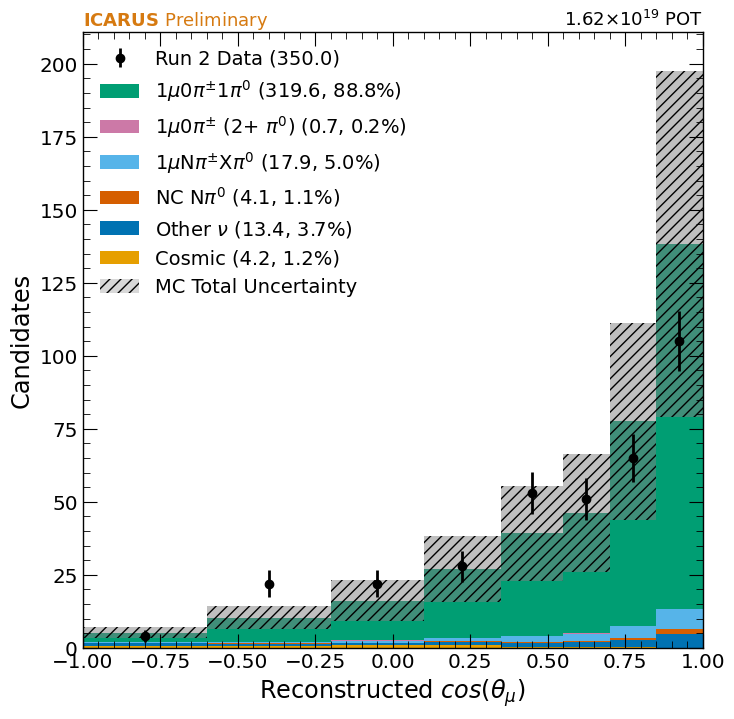

In [20]:
#histogram_mask = [li for li, label in enumerate(labels) if category_types[li] == 'histogram']
#reduce = lambda x : [x[i] for i in histogram_mask][::-1]

# normalization
scale_sim = 1.0 if not normalize else 1.0 / np.sum(reduce(data))

fig,ax = plt.subplots(figsize=figsize)
# sim
bottom = np.zeros(len(bin_centers))
for (d,l,c) in zip(reduce(data),reduce(labels),reduce(category_colors)):
    ax.bar(bin_centers, d*scale_sim, width=bin_widths, bottom=bottom, align='center', label=l, color=c)
    bottom+=d*scale_sim

# Fitting
if fit['type'] != None:
    if fit['type'] == 'double_sided_crystal_ball':
        mu = np.sum(bottom * bin_centers) / np.sum(bottom)
        sigma = np.sqrt(np.sum(bottom * (bin_centers**2)) / np.sum(bottom))
        alpha_l = 1.5
        alpha_r = 1.5
        n_l = 2.3
        n_r = 2.3
        N = max(bottom)    
        initial_guess = [mu, sigma, alpha_l, alpha_r, n_l, n_r, N]
        func = locals()[fit['type']]
        popt, cov = curve_fit(func, bin_centers[fit['start_index']:fit['end_index']], bottom[fit['start_index']:fit['end_index']], p0=initial_guess)
        mu_fit, sigma_fit, alpha_L_fit, alpha_R_fit, n_L_fit, n_R_fit, N_fit = popt
        x_fit = np.linspace(0, 400, 1000)
        y_fit = func(x_fit, *popt)
        fit_label = ''
        fit_label = '\n'
        fit_label += r"$\bf{Double}$$\bf{-}$$\bf{Sided}$ $\bf{Crystal}$ $\bf{Ball}$ $\bf{Fit}$"
        fit_label += r" $\bf{(MC)}$"
        fit_label += '\n'
        fit_label += f'$\\mu$ = {popt[0]:.2f} $\\pm$ {np.sqrt(cov[0,0]):.2f}\n'
        fit_label += f'$\\sigma$ = {popt[1]:.2f} $\\pm$ {np.sqrt(cov[1,1]):.2f}\n'
        fit_label += '\n'
   
    ax.plot(x_fit, y_fit, color='darkmagenta', label=fit_label, zorder=100)

# data
if(show_data):
    reduce = lambda x : [x[i] for i in scatter_mask]
    for i, label in enumerate(reduce(labels)):
        scale_data = 1.0 if not normalize else 1.0 / np.sum(data[scatter_mask[i]])
        nonzero_idxs = [idx for idx,val in enumerate(data[scatter_mask[i]]) if val > 0]
        ax.errorbar(bin_centers[nonzero_idxs], scale_data*data[scatter_mask[i]][nonzero_idxs], yerr=scale_data*np.sqrt(data[scatter_mask[i]][nonzero_idxs]), fmt='o', label=label, color=category_colors[scatter_mask[i]])
        max_data_y = max(scale_data*data[scatter_mask[i]][nonzero_idxs] + scale_data*np.sqrt(data[scatter_mask[i]][nonzero_idxs]))

        if fit['type'] != None:
            
            mu = np.sum(bottom * bin_centers) / np.sum(scale_data*data[scatter_mask[i]])
            sigma = np.sqrt(np.sum(scale_data*data[scatter_mask[i]] * (bin_centers**2)) / np.sum(scale_data*data[scatter_mask[i]]))
            alpha_l = 1.5
            alpha_r = 1.5
            n_l = 2.3
            n_r = 2.3
            N = max(bottom)    
            initial_guess = [mu, sigma, alpha_l, alpha_r, n_l, n_r, N]      
            popt, cov = curve_fit(func, bin_centers[fit['start_index']:fit['end_index']], scale_data*data[scatter_mask[i]][fit['start_index']:fit['end_index']], p0=initial_guess)
            mu_fit, sigma_fit, alpha_L_fit, alpha_R_fit, n_L_fit, n_R_fit, N_fit = popt
            x_fit = np.linspace(0, 400, 1000)
            y_fit = func(x_fit, *popt)
            fit_label = '\n'
            fit_label += r"$\bf{Double}$$\bf{-}$$\bf{Sided}$ $\bf{Crystal}$ $\bf{Ball}$ $\bf{Fit}$"
            fit_label += r" $\bf{(Data)}$"
            fit_label += '\n'
            fit_label += f'$\\mu$ = {popt[0]:.2f} $\\pm$ {np.sqrt(cov[0,0]):.2f}\n'
            fit_label += f'$\\sigma$ = {popt[1]:.2f} $\\pm$ {np.sqrt(cov[1,1]):.2f}\n'
            #fit_label += '\n'
            ax.plot(x_fit, y_fit, color='red', label=fit_label, zorder=101)
        
reduce = lambda x : [x[i] for i in histogram_mask[::-1]]
cov = np.sum([cov for cov in cov_mats_params.values()], axis=0)
x = bin_centers
xerr = np.diff(bin_edges)/2
y = scale_sim * np.sum(reduce(data), axis=0)
scov = transform_as(cov, scale_sim if not normalize else np.sum(reduce(data), axis=0))                                                                                                                                           
yerr = np.sqrt(np.diag(scov))
draw_error_boxes(ax, x, y, xerr, yerr, facecolor='gray', edgecolor='none', alpha=0.5, hatch='///')

# LEGEND CONFIGURATION

# sim/data with uncertainties
h, l = ax.get_legend_handles_labels()

uncert_label = "MC Total Uncertainty" if assess_systematics ==  True else "MC Statistical Uncertainty"
# legend no fits
if fit['type'] == None:
    h.append(plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.3, hatch='///'))
    l.append(uncert_label)
    ax.legend(h[-2::-1]+h[-1:], l[-2::-1]+l[-1:])
else:
    h.append(plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.3, hatch='///'))
    l.append(uncert_label)
    h, l = h[-2::-1]+h[-1:], l[-2::-1]+l[-1:]
    temp_indices = [i for i in range(len(h))]
    new_indices = temp_indices[:-3] + [temp_indices[-1], temp_indices[-3], temp_indices[-2]]
    h = [h[i] for i in new_indices]
    l = [l[i] for i in new_indices]
    ax.legend(h,l)


# cut markers for pi0 mass
#ax.axvline(60, linestyle="--", color="red")
#ax.axvline(300, linestyle="--", color="red")

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_xlim([bin_edges[0], bin_edges[-1]])

# Overrides for quick plotting
#ax.set_ylim([0.0, max_data_y + ax.get_ylim()[1]/15])
if _var_ylim:
    ax.set_ylim(_var_ylim)
else:
    ax.set_ylim([0, max(y) + ax.get_ylim()[1]/2])

#ax.set_ylim([0, 0.50]) # had. inv. mass
#ax.set_ylim([0, 75])

add_plot_labels(ax, onbeam_pot, vadj=0.0, ana_status=r"$\bf{ICARUS}$ Preliminary", title=str())
savestring = f'plots/{_vars[0]}'
if not show_data:
    savestring += '_sim'
if assess_systematics:
    savestring += '_syst'
plt.savefig(savestring + '.png')
plt.savefig(savestring + '.pdf', format='pdf')
plt.show()

In [21]:
yerr

array([ 1.91014862,  3.92956951,  6.88959191, 11.1680889 , 16.30929282,
       20.05966944, 33.57213519, 59.08492533])

## Summary of uncertainties

In [22]:
# Flux summary
params_multisim_flux_stds = []
for k,v in cov_stds_params.items():
    if k in params_multisim_flux:
        params_multisim_flux_stds.append(v)
        print(f'Parameter: {k}, Uncertainty: {v:.1%}')
multisim_flux_total_std = np.sqrt(np.sum([v**2 for v in params_multisim_flux_stds]))
print(f'Total Multisim Flux Uncertainty: {multisim_flux_total_std:.1%}')

Parameter: expskin_Flux, Uncertainty: 6.1%
Parameter: horncurrent_Flux, Uncertainty: 0.8%
Parameter: nucleoninexsec_Flux, Uncertainty: 0.8%
Parameter: nucleonqexsec_Flux, Uncertainty: 2.5%
Parameter: nucleontotxsec_Flux, Uncertainty: 0.7%
Parameter: pioninexsec_Flux, Uncertainty: 1.3%
Parameter: pionqexsec_Flux, Uncertainty: 0.9%
Parameter: piontotxsec_Flux, Uncertainty: 1.0%
Parameter: piplus_Flux, Uncertainty: 5.3%
Parameter: piminus_Flux, Uncertainty: 0.1%
Parameter: kplus_Flux, Uncertainty: 0.6%
Parameter: kminus_Flux, Uncertainty: 0.0%
Parameter: kzero_Flux, Uncertainty: 0.0%
Total Multisim Flux Uncertainty: 8.8%


In [23]:
# Multisigma x-sec summary
params_multisigma_xsec_stds = []
for k,v in cov_stds_params.items():
    if k in params_multisigma_xsec:
        params_multisigma_xsec_stds.append(v)
        print(f'Parameter: {k}, Uncertainty: {v:.1%}')
multisigma_xsec_total_std = np.sqrt(np.sum([v**2 for v in params_multisigma_xsec_stds]))
print(f'Total Multisigma X-Sec Uncertainty: {multisigma_xsec_total_std:.1%}')

Parameter: cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b1, Uncertainty: 0.1%
Parameter: cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b2, Uncertainty: 0.6%
Parameter: cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b3, Uncertainty: 0.2%
Parameter: cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b4, Uncertainty: 0.2%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_RPA_CCQE, Uncertainty: 1.2%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_CoulombCCQE, Uncertainty: 0.0%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_NormCCMEC, Uncertainty: 0.4%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_NormNCMEC, Uncertainty: 0.0%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_MaCCRES, Uncertainty: 14.7%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_MvCCRES, Uncertainty: 12.5%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_MaNCRES, Uncertainty: 0.2%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_

In [24]:
# Multisim x-sec summary
params_multisim_xsec_stds = []
for k,v in cov_stds_params.items():
    if k in params_multisim_xsec:
        params_multisim_xsec_stds.append(v)
        print(f'Parameter: {k}, Uncertainty: {v:.2%}')
multisim_xsec_total_std = np.sqrt(np.sum([v**2 for v in params_multisim_xsec_stds]))
print(f'Total Multisim X-Sec Uncertainty: {multisim_xsec_total_std:.2%}')

Total Multisim X-Sec Uncertainty: 0.00%


In [25]:
# Total x-sec summary
params_xsec_stds = []
for k,v in cov_stds_params.items():
    if k in params_multisim_xsec or k in params_multisigma_xsec:
        params_xsec_stds.append(v)
        print(f'Parameter: {k}, Uncertainty: {v:.2%}')
xsec_total_std = np.sqrt(np.sum([v**2 for v in params_xsec_stds]))
print(f'Total X-Sec Uncertainty: {xsec_total_std:.2%}')

Parameter: cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b1, Uncertainty: 0.13%
Parameter: cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b2, Uncertainty: 0.56%
Parameter: cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b3, Uncertainty: 0.19%
Parameter: cov_weights_ZExpPCAWeighter_SBNNuSyst_ZExpPCA_multisigma_b4, Uncertainty: 0.18%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_RPA_CCQE, Uncertainty: 1.20%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_CoulombCCQE, Uncertainty: 0.02%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_NormCCMEC, Uncertainty: 0.42%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_NormNCMEC, Uncertainty: 0.00%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_MaCCRES, Uncertainty: 14.66%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_MvCCRES, Uncertainty: 12.46%
Parameter: cov_weights_GENIEReWeight_SBN_v1_multisigma_MaNCRES, Uncertainty: 0.22%
Parameter: cov_weights_GENIEReWeight_SBN_v1_

In [26]:
# Det sys summary
params_det_stds = []
for k,v in cov_stds_params.items():
    if k in params_detsys:
        params_det_stds.append(v)
        print(f'Parameter: {k}, Uncertainty: {v:.1%}')
det_sys_total_std = np.sqrt(np.sum([v**2 for v in params_det_stds]))
print(f'Total Detector Model Uncertainty: {det_sys_total_std:.1%}')

Parameter: cov_weights_var01, Uncertainty: 0.2%
Parameter: cov_weights_var04, Uncertainty: 0.7%
Parameter: cov_weights_var05, Uncertainty: 29.2%
Parameter: cov_weights_var06, Uncertainty: 6.5%
Parameter: cov_weights_var07, Uncertainty: 1.3%
Parameter: cov_weights_var10, Uncertainty: 2.4%
Parameter: cov_weights_var11, Uncertainty: 0.4%
Parameter: cov_weights_var12, Uncertainty: 2.1%
Parameter: cov_weights_var13, Uncertainty: 0.6%
Total Detector Model Uncertainty: 30.2%


In [27]:
# Statistical uncertainty summary
stat_stds = []
for k,v in cov_stds_params.items():
    if 'stat' in k:
        print(k,v)
        stat_stds.append(v)
        print(f'Parameter: {k}, Uncertainty: {v:.2%}')
stat_total_std = np.sqrt(np.sum([v**2 for v in stat_stds]))
print(f'Total Statistial Uncertainty: {stat_total_std:.2%}')

sim_stat 0.005212718703386642
Parameter: sim_stat, Uncertainty: 0.52%
offbeam_stat 0.1543033499620919
Parameter: offbeam_stat, Uncertainty: 15.43%
Total Statistial Uncertainty: 15.44%


## Convert multisim covariance matrices to ROOT format

In [28]:
if assess_systematics:

    # X-Sec
    multisim_xsec_cov = np.sum([v for k,v in cov_mats_params.items() if k in params_multisim_xsec], axis=0)
    multisim_xsec_cov /= np.outer(bottom, bottom)
    multisim_xsec_cov_tmatrix = ndarray_to_tmatrixtsym(multisim_xsec_cov)
    outf = ROOT.TFile(f'{_vars[0]}_multisim_xsec_cov.root', 'RECREATE')
    outf.WriteObject(multisim_xsec_cov_tmatrix, f'{_vars[0]}_multisim_xsec_cov')
    outf.Close()
    
    # Plot
    tmatrix_file = ROOT.TFile.Open(f'{_vars[0]}_multisim_xsec_cov.root', 'READ')
    tmatrix = tmatrix_file.Get(f'{_vars[0]}_multisim_xsec_cov')
    c1 = ROOT.TCanvas('c1', '', 800, 600)
    tmatrix.Draw('COLZ TEXT')
    c1.Update()

In [29]:
if assess_systematics:

    #Flux
    multisim_flux_cov = np.sum([v for k,v in cov_mats_params.items() if k in params_multisim_flux], axis=0)
    multisim_flux_cov /= np.outer(bottom, bottom)
    multisim_flux_cov_tmatrix = ndarray_to_tmatrixtsym(multisim_flux_cov)
    outf = ROOT.TFile(f'{_vars[0]}_multisim_flux_cov.root', 'RECREATE')
    outf.WriteObject(multisim_flux_cov_tmatrix, f'{_vars[0]}_multisim_flux_cov')
    outf.Close()
    
    # Plot
    tmatrix_file = ROOT.TFile.Open(f'{_vars[0]}_multisim_flux_cov.root', 'READ')
    tmatrix = tmatrix_file.Get(f'{_vars[0]}_multisim_flux_cov')
    c2 = ROOT.TCanvas('c2', '', 800, 600)
    tmatrix.Draw('COLZ TEXT')
    c2.Update()